In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats import diagnostic

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from datetime import datetime

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import f_oneway

import warnings
warnings.simplefilter('ignore')

In [2]:
promotion = pd.read_csv('./promotion.csv')

In [3]:
promotion.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
promotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
# It's not going to influenced in any decision and might cause some model biased learning
promotion_cleaned = promotion.drop('employee_id', axis=1)

In [6]:
promotion_cleaned = promotion_cleaned.rename(columns = {'KPIs_met >80%':'kpis_met_80', 'awards_won?':'awards_won'})

In [7]:
promotion_cleaned.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
kpis_met_80                0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
# It seems that there are employees that might not have a previous perfomance rating over the last year, these employees shouldn't be considered to have a promotion

In [9]:
promotion_cleaned['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [10]:
filter_by_previous_rating = promotion_cleaned[promotion_cleaned['previous_year_rating'].isna()]
filter_by_previous_rating

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,R&D,region_31,Bachelor's,m,sourcing,1,30,NaN,1,1,0,88,0
54734,Operations,region_15,Bachelor's,m,sourcing,1,31,NaN,1,1,0,56,1
54746,Finance,region_6,Bachelor's,m,other,1,28,NaN,1,1,0,61,0
54773,Finance,region_2,Bachelor's,m,other,1,23,NaN,1,1,0,61,0


In [11]:
filter_by_previousrating_lengthservice = promotion_cleaned[(promotion_cleaned['previous_year_rating'].isna()) & (promotion_cleaned['length_of_service'] <= 1)]
filter_by_previousrating_lengthservice

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,R&D,region_31,Bachelor's,m,sourcing,1,30,NaN,1,1,0,88,0
54734,Operations,region_15,Bachelor's,m,sourcing,1,31,NaN,1,1,0,56,1
54746,Finance,region_6,Bachelor's,m,other,1,28,NaN,1,1,0,61,0
54773,Finance,region_2,Bachelor's,m,other,1,23,NaN,1,1,0,61,0


In [12]:
comparison = filter_by_previousrating_lengthservice.index == filter_by_previous_rating.index
set(comparison)

{True}

In [13]:
promotion_cleaned = promotion_cleaned.drop(filter_by_previous_rating.index)

In [14]:
# promotion_cleaned['previous_year_rating'] = promotion_cleaned['previous_year_rating'].fillna(0.0).reset_index(drop=True)

In [15]:
promotion_cleaned.isna().sum()

department                 0
region                     0
education               2024
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
kpis_met_80                0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [16]:
promotion_cleaned['is_promoted'].value_counts()

0    46355
1     4329
Name: is_promoted, dtype: int64

In [17]:
promotion_cleaned[(promotion_cleaned['education'].isna()) & (promotion_cleaned['is_promoted'])]

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
323,Sales & Marketing,region_2,NaN,m,other,1,22,5.0,2,0,0,62,1
359,Sales & Marketing,region_28,NaN,m,other,1,24,2.0,2,1,0,52,1
574,Sales & Marketing,region_2,NaN,m,other,1,24,3.0,2,1,1,81,1
867,Sales & Marketing,region_28,NaN,m,other,1,25,4.0,3,1,0,64,1
1585,Sales & Marketing,region_28,NaN,m,other,1,34,5.0,7,1,0,53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52061,Sales & Marketing,region_28,NaN,m,other,1,31,5.0,6,1,0,51,1
52123,Sales & Marketing,region_2,NaN,m,sourcing,1,24,4.0,3,1,1,92,1
53064,Sales & Marketing,region_2,NaN,m,other,1,32,5.0,5,1,0,48,1
53612,Sales & Marketing,region_22,NaN,m,other,1,24,4.0,2,0,0,98,1


In [18]:
len(promotion_cleaned[(promotion_cleaned['education'].isna()) & (promotion_cleaned['is_promoted'])])/len(promotion_cleaned[promotion_cleaned['is_promoted']==1])

0.022407022407022407

In [19]:
promotion_cleaned.isna().mean() * 100

department              0.000000
region                  0.000000
education               3.993371
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    0.000000
length_of_service       0.000000
kpis_met_80             0.000000
awards_won              0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

In [20]:
# Since the representation of nulls is about 4% of the entire dataset and 2% of the promoted employees I decided to cleansed this data.
# promotion_cleaned['education'] = promotion_cleaned['education'].fillna('not_specified').reset_index(drop=True)
promotion_cleaned = promotion_cleaned.dropna()

In [21]:
promotion_cleaned.isna().mean() * 100

department              0.0
region                  0.0
education               0.0
gender                  0.0
recruitment_channel     0.0
no_of_trainings         0.0
age                     0.0
previous_year_rating    0.0
length_of_service       0.0
kpis_met_80             0.0
awards_won              0.0
avg_training_score      0.0
is_promoted             0.0
dtype: float64

In [22]:
promotion_cleaned.nunique()

department               9
region                  34
education                3
gender                   2
recruitment_channel      3
no_of_trainings         10
age                     41
previous_year_rating     5
length_of_service       35
kpis_met_80              2
awards_won               2
avg_training_score      61
is_promoted              2
dtype: int64

In [23]:
# Dividing our dataset in numerical and categorical variables
prom_numerical = promotion_cleaned.select_dtypes(include='number')
prom_categorical = promotion_cleaned.select_dtypes(include='object')

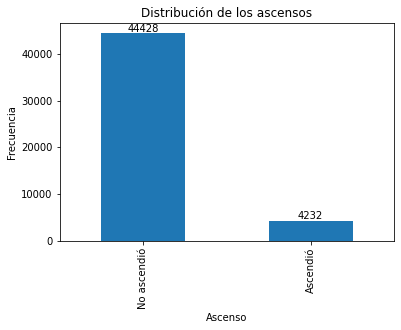

In [24]:
promotion_count = promotion_cleaned['is_promoted'].value_counts()
plot = promotion_count.plot.bar()
plt.title('Distribución de los ascensos')
plt.ylabel('Frecuencia')
plt.xlabel('Ascenso')
plt.xticks(range(2),['No ascendió', 'Ascendió'])

for p in plot.patches:
     plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

In [25]:
4232/44428

0.09525524444044296

In [26]:
promotion_corr = prom_numerical.corr()
promotion_corr

,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.083590,-0.064236,-0.055440,-0.046673,-0.008528,0.042033,-0.025006
age,-0.083590,1.000000,0.005068,0.620348,-0.033886,-0.010335,-0.066214,-0.022412
previous_year_rating,-0.064236,0.005068,1.000000,-0.001252,0.352434,0.027920,0.070041,0.158715
length_of_service,-0.055440,0.620348,-0.001252,1.000000,-0.089081,-0.043750,-0.047461,-0.014267
kpis_met_80,-0.046673,-0.033886,0.352434,-0.089081,1.000000,0.095208,0.074114,0.219933
awards_won,-0.008528,-0.010335,0.027920,-0.043750,0.095208,1.000000,0.073132,0.196971
avg_training_score,0.042033,-0.066214,0.070041,-0.047461,0.074114,0.073132,1.000000,0.179494
is_promoted,-0.025006,-0.022412,0.158715,-0.014267,0.219933,0.196971,0.179494,1.000000


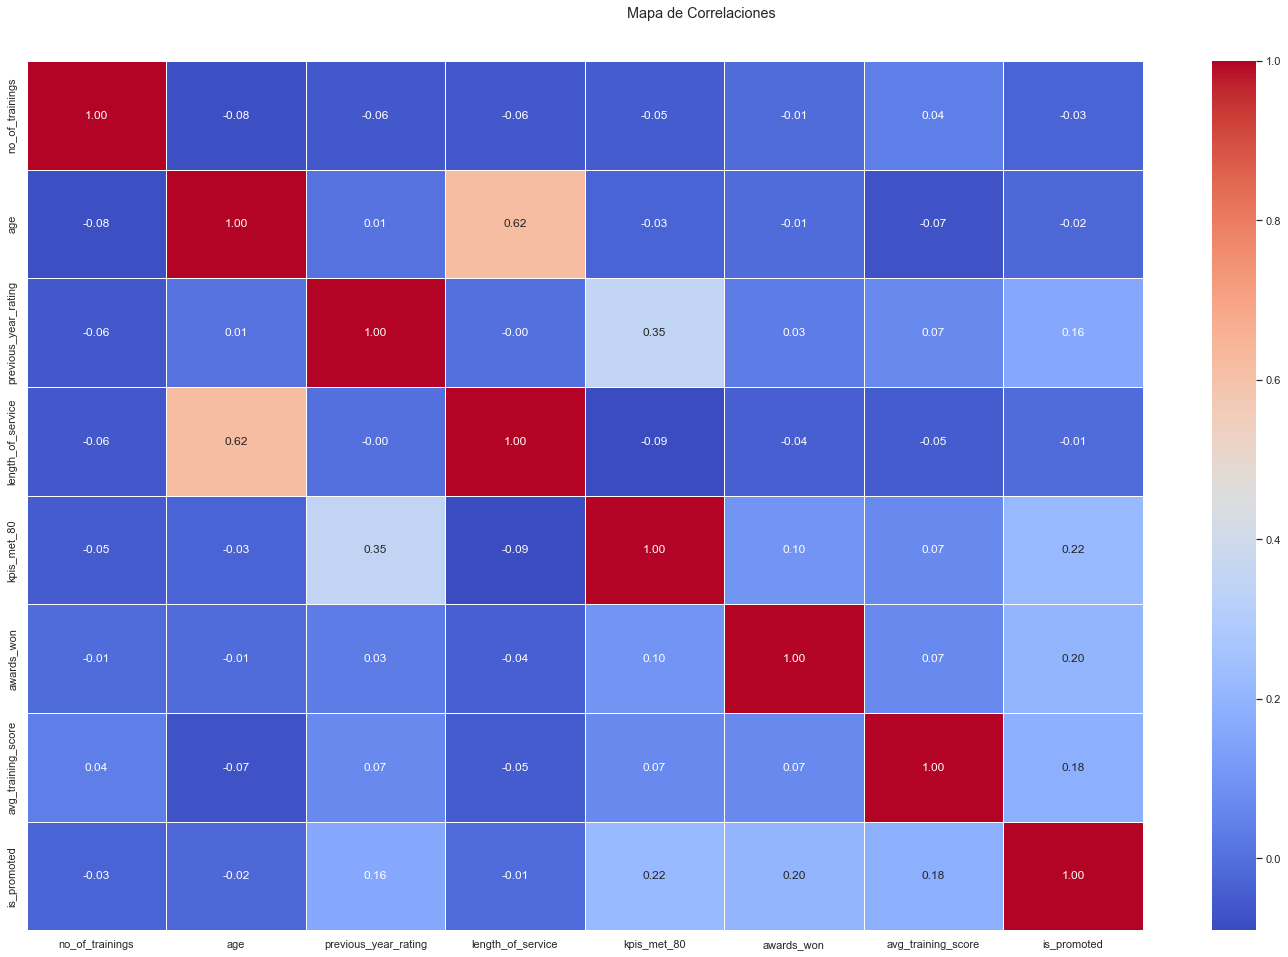

In [27]:
sns.set()

fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(round(promotion_corr, 2), annot=True, ax=ax, cmap='coolwarm',
            fmt='.2f', linewidths=0.5)
fig.subplots_adjust(top=0.93)
fig.suptitle('Mapa de Correlaciones');

(0.47118599343686696, 0.0009999999999998899)


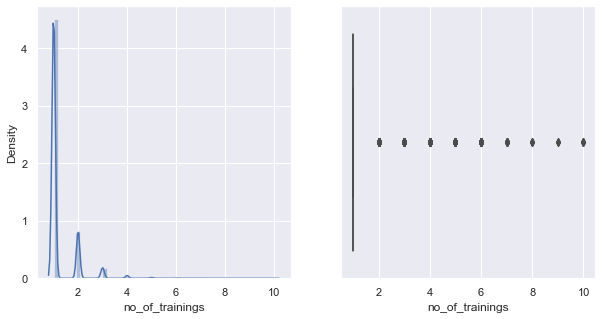


(0.11818976175096663, 0.0009999999999998899)


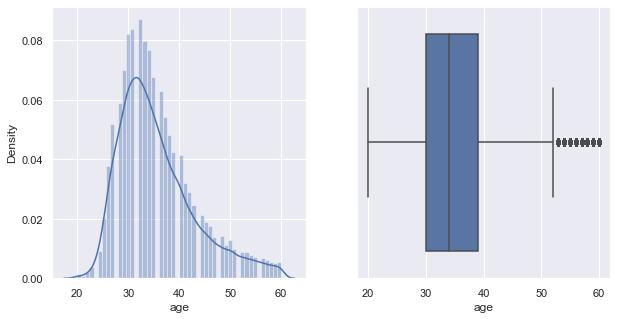


(0.19032187473206472, 0.0009999999999998899)


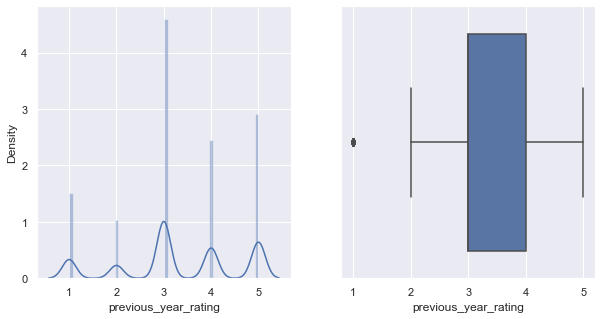


(0.16286067050250452, 0.0009999999999998899)


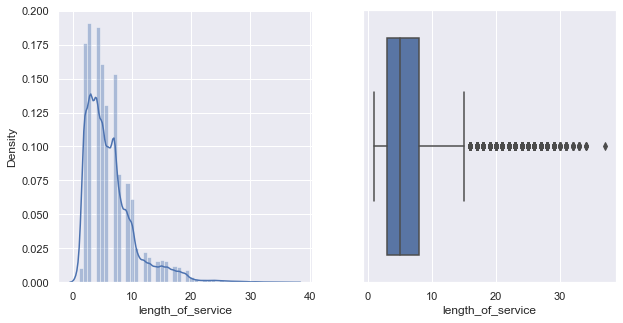


(0.4151675638366315, 0.0009999999999998899)


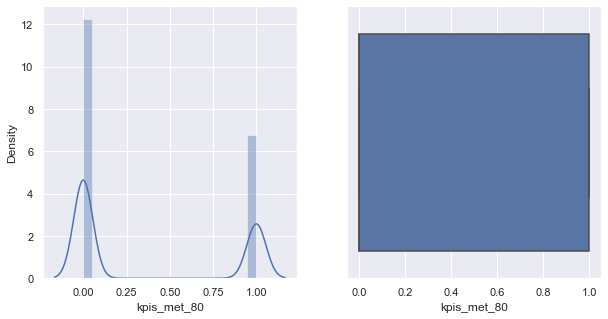


(0.5380188953320623, 0.0009999999999998899)


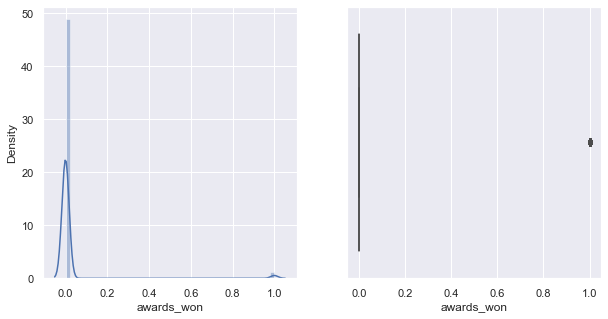


(0.11488032938111015, 0.0009999999999998899)


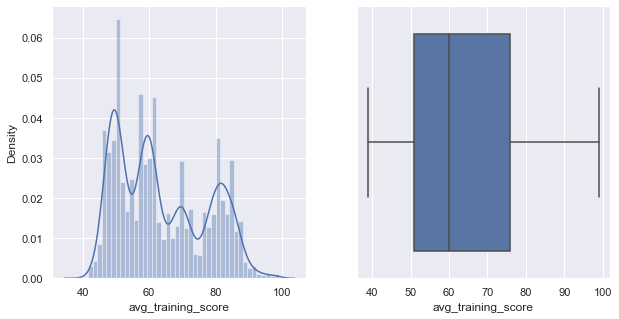


(0.5342281824737283, 0.0009999999999998899)


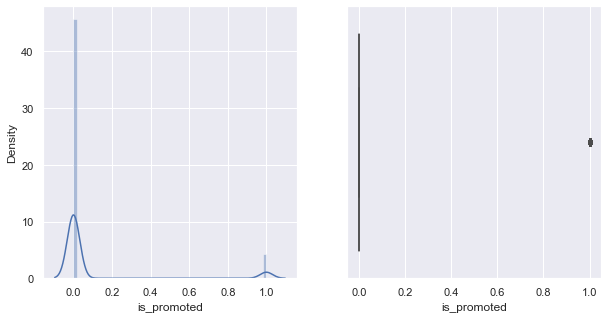

In [28]:
for column in prom_numerical:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(prom_numerical[column], kde=True, ax=ax[0])
    sns.boxplot(prom_numerical[column], orient='h', ax=ax[1])
    print(diagnostic.kstest_normal(prom_numerical[column]))
    plt.show()
    print('');

department   Analytics  Finance    HR  Legal  Operations  Procurement   R&D  \
is_promoted                                                                   
0                  0.9     0.92  0.94   0.95        0.91          0.9  0.94   
1                  0.1     0.08  0.06   0.05        0.09          0.1  0.06   

department   Sales & Marketing  Technology  
is_promoted                                 
0                         0.93        0.89  
1                         0.07        0.11  
AxesSubplot(0.125,0.125;0.775x0.755)
region       region_1  region_10  region_11  region_12  region_13  region_14  \
is_promoted                                                                    
0                 0.9       0.92       0.94       0.94       0.91       0.93   
1                 0.1       0.08       0.06       0.06       0.09       0.07   

region       region_15  region_16  region_17  region_18  ...  region_31  \
is_promoted                                              ...          

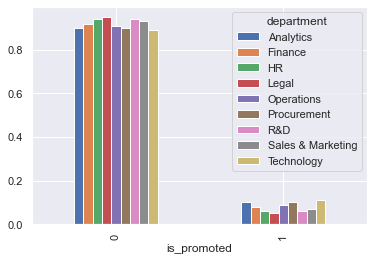

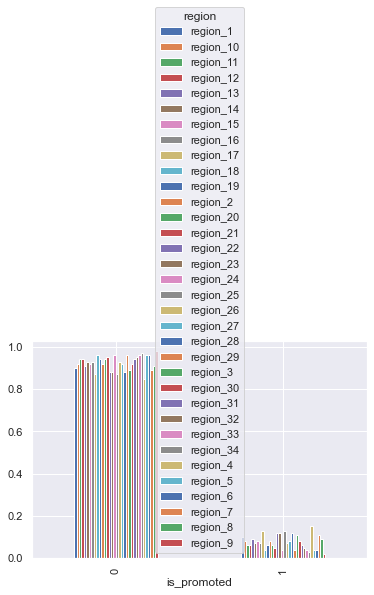

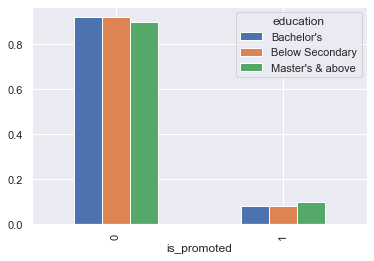

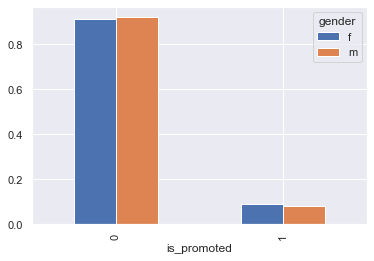

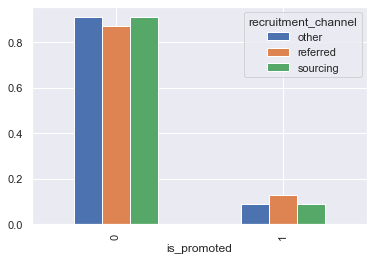

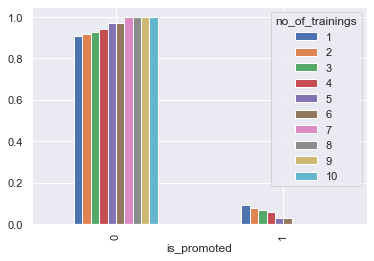

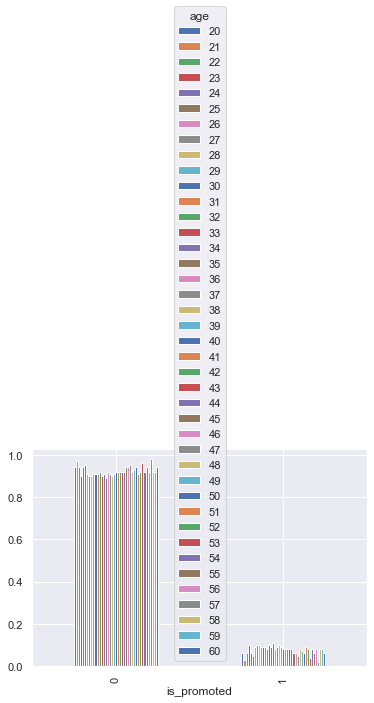

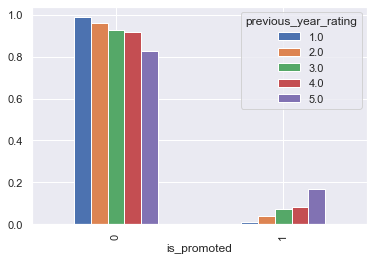

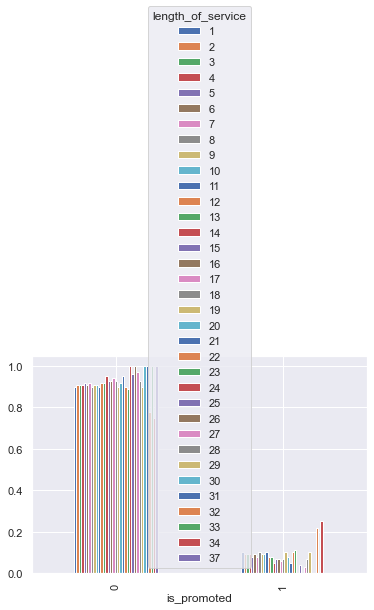

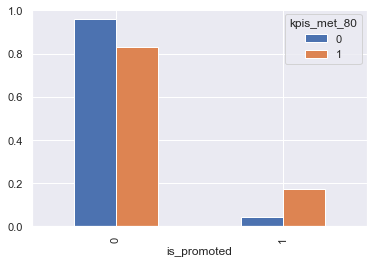

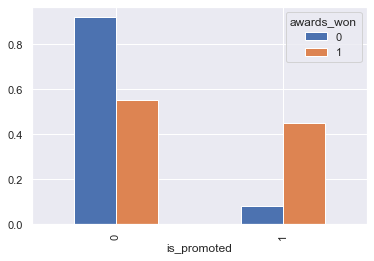

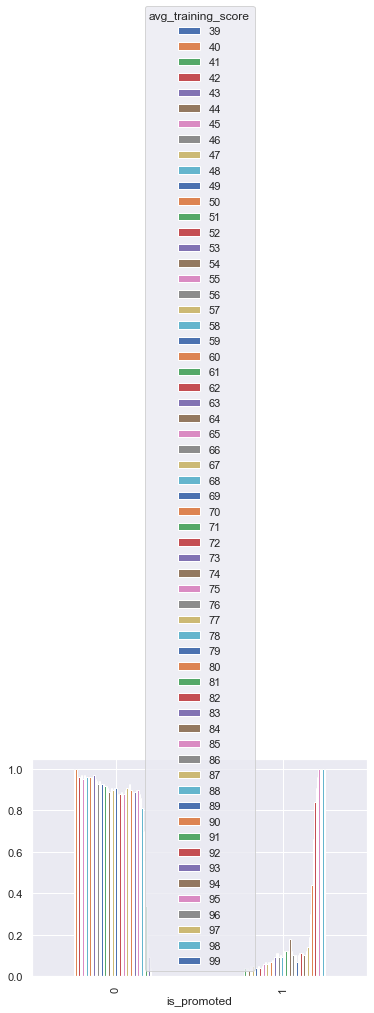

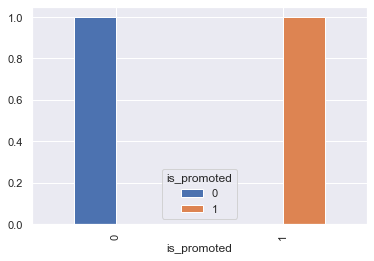

In [29]:
for column in promotion_cleaned:
    promo_by_group = pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned[column], normalize = 'columns')
    promo_by_group = promo_by_group.apply(lambda x: round(x,2))
    print(promo_by_group)
    print(promo_by_group.plot.bar())


In [30]:
# age_log = np.log1p(promotion_cleaned['age'])
# service_log = np.log1p(promotion_cleaned['length_of_service'])
# score_log = np.log1p(promotion_cleaned['avg_training_score'])

# promotion_cleaned.insert(6, 'age_log', age_log)
# promotion_cleaned.insert(9, 'length_of_service_log', service_log)
# promotion_cleaned.insert(12, 'avg_training_score_log', score_log)

# promotion_cleaned.head()

Sales & Marketing    14239
Operations           10547
Procurement           6641
Technology            6502
Analytics             4610
Finance               2219
HR                    2142
R&D                    893
Legal                  867
Name: department, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)
region_2     10811
region_22     5435
region_7      4397
region_15     2512
region_13     2463
region_26     1966
region_31     1692
region_4      1626
region_27     1418
region_16     1319
region_11     1189
region_28     1143
region_23     1104
region_29      896
region_19      838
region_20      780
region_32      773
region_14      770
region_17      742
region_25      721
region_5       690
region_10      614
region_30      602
region_6       579
region_8       578
region_1       553
region_24      462
region_12      425
region_21      370
region_3       331
region_9       324
region_33      260
region_34      253
region_18       24
Name: region, dtype: int64
AxesSubplot(0.12

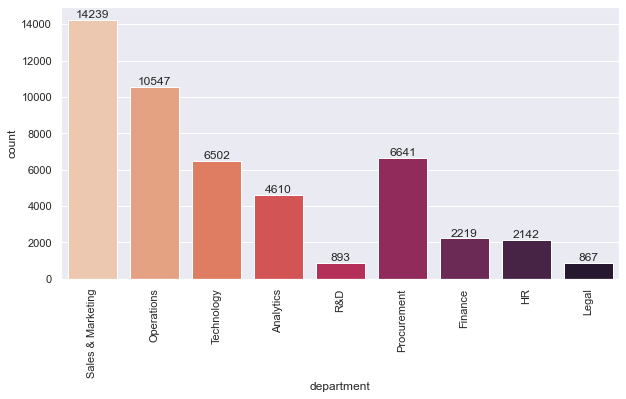

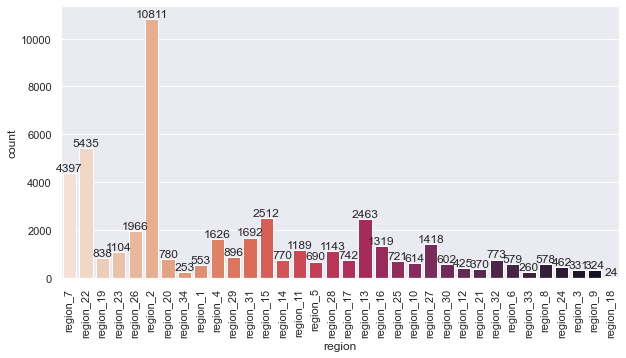

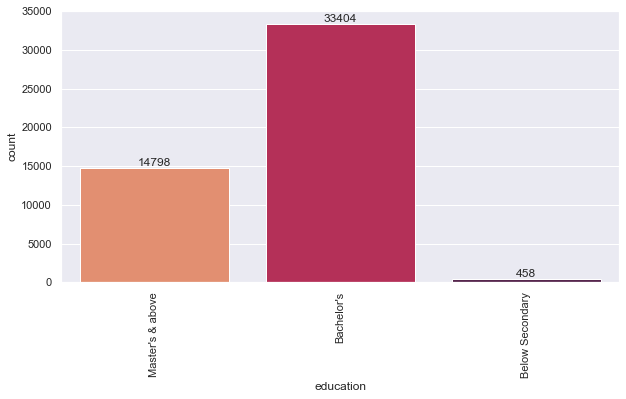

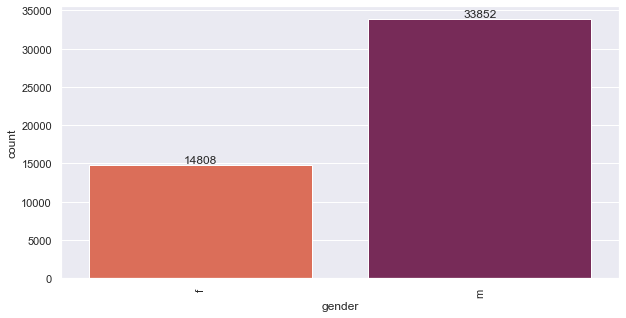

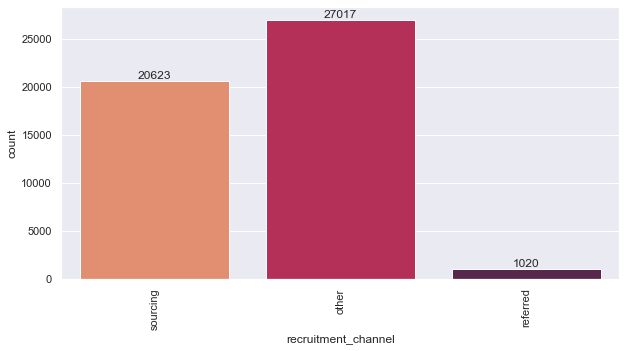

In [31]:
for column in prom_categorical:
    plt.figure(figsize = (10, 5))
    print(prom_categorical[column].value_counts())
    plot = sns.countplot(x = column, data = promotion_cleaned, palette='rocket_r')
    print(plot)
    sns.color_palette("magma", as_cmap=True)
    plt.xticks(rotation = 90)
    for p in plot.patches:
         plot.annotate(p.get_height(), 
                            (p.get_x() + p.get_width() / 2.0, 
                             p.get_height()), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

In [32]:
promotion['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [33]:
promotion['department'].value_counts()

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [34]:
promotion[promotion['age']>30]['is_promoted'].value_counts()

0    33572
1     3118
Name: is_promoted, dtype: int64

In [35]:
promotion[promotion['age']<30]['is_promoted'].value_counts()

0    13227
1     1226
Name: is_promoted, dtype: int64

In [36]:
promotion_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            48660 non-null  object 
 1   region                48660 non-null  object 
 2   education             48660 non-null  object 
 3   gender                48660 non-null  object 
 4   recruitment_channel   48660 non-null  object 
 5   no_of_trainings       48660 non-null  int64  
 6   age                   48660 non-null  int64  
 7   previous_year_rating  48660 non-null  float64
 8   length_of_service     48660 non-null  int64  
 9   kpis_met_80           48660 non-null  int64  
 10  awards_won            48660 non-null  int64  
 11  avg_training_score    48660 non-null  int64  
 12  is_promoted           48660 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.2+ MB


In [37]:
total = 1363 + 2869

In [38]:
1363 / total, 2869/total

(0.32206994328922495, 0.677930056710775)

In [39]:
 pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['recruitment_channel'])
    
# 2303/total

recruitment_channel,other,referred,sourcing
is_promoted,,,
0,24714,890,18824
1,2303,130,1799


In [40]:
sourced =  pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['length_of_service'])
sourced

length_of_service,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,37
is_promoted,,,,,,,,,,,,,,,,,,,,,
0,343,5620,6087,6000,5154,4188,4928,2537,2327,1941,...,41,35,27,27,12,19,7,9,3,1
1,37,565,593,585,468,394,457,267,228,199,...,0,1,2,3,0,0,2,0,1,0


In [41]:
rating = pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['awards_won'])
print((3278)/total)
rating

0.7745746691871456


awards_won,0,1
is_promoted,,
0,43806,622
1,3728,504


In [42]:
1363 / total, 2869/total

(0.32206994328922495, 0.677930056710775)

<AxesSubplot:xlabel='age'>

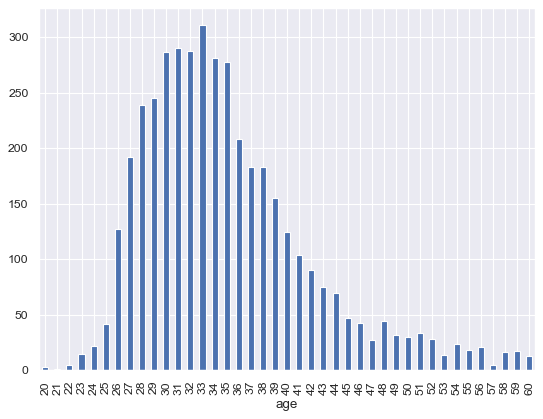

In [43]:
ages =  pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['age'])

plt.figure(figsize=(8, 6), dpi=80)
ages.iloc[1].plot(kind='bar')

In [44]:
1363/(2869+1363)

0.32206994328922495

<AxesSubplot:xlabel='gender,is_promoted'>

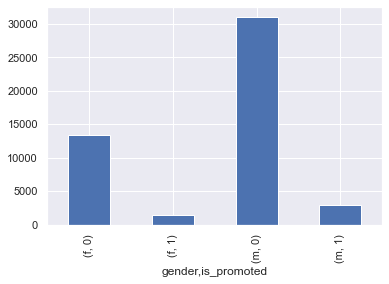

In [45]:
promotion_cleaned.groupby(['gender', 'is_promoted'])['is_promoted'].count().plot(kind='bar')

In [46]:
education =  pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['education'])
education
# plt.figure(figsize=(8, 6), dpi=80)
# ages.iloc[1].plot(kind='bar')
36/total, 2733/total, 1463/total

(0.008506616257088847, 0.6457939508506616, 0.3456994328922495)

AxesSubplot(0.125,0.125;0.775x0.755)
department
Analytics             445
Finance               182
HR                    121
Legal                  42
Operations            979
Procurement           651
R&D                    58
Sales & Marketing    1060
Technology            694
Name: 1, dtype: int64
0.2504725897920605 0.23133270321361057 0.16398865784499056


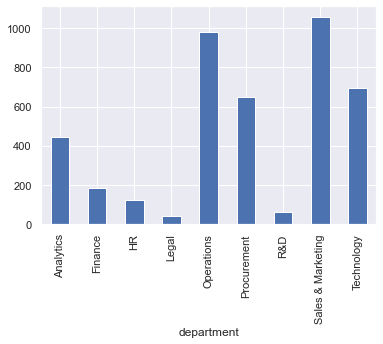

In [47]:
department =  pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['department'])
# print(labels_ordered_by_mean_dict)
print(department.iloc[1].plot(kind='bar'))
print(department.iloc[1])
print(1060/total, 979/total, 694/total)

AxesSubplot(0.125,0.125;0.775x0.755)
awards_won
0    3728
1     504
Name: 1, dtype: int64
0.30222117202268434 0.6977788279773157


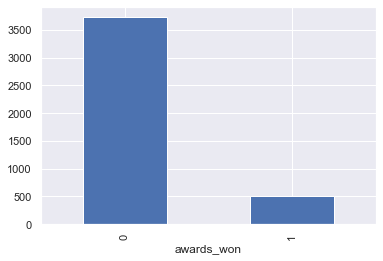

In [48]:
kpi =  pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['awards_won'])
print(kpi.iloc[1].plot(kind='bar'))
print(kpi.iloc[1])
print(1279/total, 2953/total)



In [49]:
promotion_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            48660 non-null  object 
 1   region                48660 non-null  object 
 2   education             48660 non-null  object 
 3   gender                48660 non-null  object 
 4   recruitment_channel   48660 non-null  object 
 5   no_of_trainings       48660 non-null  int64  
 6   age                   48660 non-null  int64  
 7   previous_year_rating  48660 non-null  float64
 8   length_of_service     48660 non-null  int64  
 9   kpis_met_80           48660 non-null  int64  
 10  awards_won            48660 non-null  int64  
 11  avg_training_score    48660 non-null  int64  
 12  is_promoted           48660 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.2+ MB


In [50]:
promotion_cleaned[promotion_cleaned['is_promoted'] == 1].describe()

,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
count,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.0
mean,1.202977,35.042297,3.984405,6.117202,0.697779,0.119093,71.322779,1.0
std,0.510037,6.979245,1.052731,3.940465,0.459275,0.323936,14.641829,0.0
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,41.000000,1.0
25%,1.000000,30.000000,3.000000,3.000000,0.000000,0.000000,59.000000,1.0
50%,1.000000,34.000000,4.000000,5.000000,1.000000,0.000000,71.000000,1.0
75%,1.000000,38.000000,5.000000,8.000000,1.000000,0.000000,83.000000,1.0
max,6.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000,1.0


In [51]:
lenght_of_service =  pd.crosstab(index=promotion_cleaned['is_promoted'],columns = promotion_cleaned['length_of_service']).T
lenght_of_service[0:5][1].sum()
# print(1279/total, 2953/total)



2248

<AxesSubplot:xlabel='awards_won,is_promoted'>

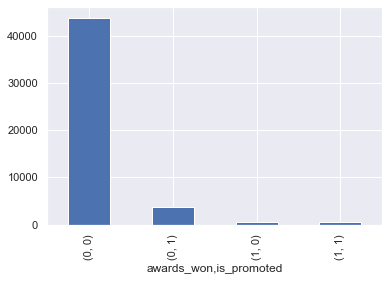

In [52]:
promotion_cleaned.groupby(['awards_won', 'is_promoted'])['awards_won'].count().plot(kind='bar')

In [53]:
promotion_cleaned.groupby('kpis_met_80')['kpis_met_80'].count()

kpis_met_80
0    31314
1    17346
Name: kpis_met_80, dtype: int64

In [54]:
promotion_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            48660 non-null  object 
 1   region                48660 non-null  object 
 2   education             48660 non-null  object 
 3   gender                48660 non-null  object 
 4   recruitment_channel   48660 non-null  object 
 5   no_of_trainings       48660 non-null  int64  
 6   age                   48660 non-null  int64  
 7   previous_year_rating  48660 non-null  float64
 8   length_of_service     48660 non-null  int64  
 9   kpis_met_80           48660 non-null  int64  
 10  awards_won            48660 non-null  int64  
 11  avg_training_score    48660 non-null  int64  
 12  is_promoted           48660 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.2+ MB


In [55]:
len(promotion_cleaned['region'].unique())

34

In [56]:
38496 / len(promotion)

0.7023792147131805

In [57]:
region_map = promotion_cleaned['region'].value_counts().to_dict()

promotion_cleaned['region']=promotion_cleaned['region'].map(region_map)
promotion_cleaned.head(20)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted
0,Sales & Marketing,4397,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,5435,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,838,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,1104,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,1966,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
5,Analytics,10811,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0
6,Operations,780,Bachelor's,f,other,1,31,3.0,5,0,0,59,0
7,Operations,253,Master's & above,m,sourcing,1,33,3.0,6,0,0,63,0
8,Analytics,780,Bachelor's,m,other,1,28,4.0,5,0,0,83,0
9,Sales & Marketing,553,Master's & above,m,sourcing,1,32,5.0,5,1,0,54,0


In [58]:
promotion_cleaned['education'] = promotion_cleaned['education'].replace({"not_specified":4, "Master's & above":3,"Bachelor's":2,'Below Secondary':1})
promotion_cleaned['education'].unique()

array([3, 2, 1])

In [59]:
f_oneway(promotion['is_promoted'], promotion['avg_training_score'])

F_onewayResult(statistic=1227777.6291747647, pvalue=0.0)

In [60]:
promotion_cleaned['department'].value_counts()
labels_ordered_by_mean = promotion_cleaned.groupby(['department'])['is_promoted'].mean().sort_values().index
labels_ordered_by_mean_dict = {k:v for v,k in enumerate(labels_ordered_by_mean)}
promotion_cleaned['department'] = promotion_cleaned['department'].map(labels_ordered_by_mean_dict)
promotion_cleaned['department'].unique()

array([3, 5, 8, 6, 2, 7, 4, 1, 0])

<AxesSubplot:>

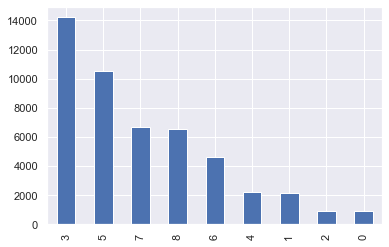

In [61]:
promotion_cleaned['department'].value_counts().plot(kind='bar')

In [62]:
promotion_cleaned_dummies = pd.get_dummies(promotion_cleaned, drop_first=True)
promotion_cleaned_dummies

,department,region,education,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_80,awards_won,avg_training_score,is_promoted,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,3,4397,3,1,35,5.0,8,1,0,49,0,0,0,1
1,5,5435,2,1,30,5.0,4,0,0,60,0,1,0,0
2,3,838,2,1,34,3.0,7,0,0,50,0,1,0,1
3,3,1104,2,2,39,1.0,10,0,0,50,0,1,0,0
4,8,1966,2,1,45,3.0,2,0,0,73,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54802,3,770,2,2,31,1.0,2,0,0,49,0,1,0,0
54803,8,770,2,1,48,3.0,17,0,0,78,0,1,0,1
54804,5,1418,3,1,37,2.0,6,0,0,56,0,0,0,0
54805,6,553,2,1,27,5.0,3,1,0,79,0,1,0,0


In [63]:
dummies_corr = promotion_cleaned_dummies.drop(['age','length_of_service', 'avg_training_score'], axis=1).corr()
dummies_corr

,department,region,education,no_of_trainings,previous_year_rating,kpis_met_80,awards_won,is_promoted,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
department,1.000000,-0.011950,0.034209,0.039862,0.015569,0.057351,0.009546,0.050103,-0.136718,0.031133,-0.005411
region,-0.011950,1.000000,0.044347,0.080350,0.015302,0.016771,-0.005073,0.009713,-0.117643,0.130436,0.000241
education,0.034209,0.044347,1.000000,-0.036286,0.010256,0.002989,-0.001961,0.027547,-0.021494,-0.033021,-0.000747
no_of_trainings,0.039862,0.080350,-0.036286,1.000000,-0.064236,-0.046673,-0.008528,-0.025006,0.085456,-0.015895,-0.009477
previous_year_rating,0.015569,0.015302,0.010256,-0.064236,1.000000,0.352434,0.027920,0.158715,-0.022828,0.070560,-0.004721
kpis_met_80,0.057351,0.016771,0.002989,-0.046673,0.352434,1.000000,0.095208,0.219933,-0.038172,0.045645,-0.005952
awards_won,0.009546,-0.005073,-0.001961,-0.008528,0.027920,0.095208,1.000000,0.196971,0.002275,0.001333,-0.006146
is_promoted,0.050103,0.009713,0.027547,-0.025006,0.158715,0.219933,0.196971,1.000000,-0.011909,0.021020,0.000797
gender_m,-0.136718,-0.117643,-0.021494,0.085456,-0.022828,-0.038172,0.002275,-0.011909,1.000000,0.009479,0.001889
recruitment_channel_referred,0.031133,0.130436,-0.033021,-0.015895,0.070560,0.045645,0.001333,0.021020,0.009479,1.000000,-0.125494


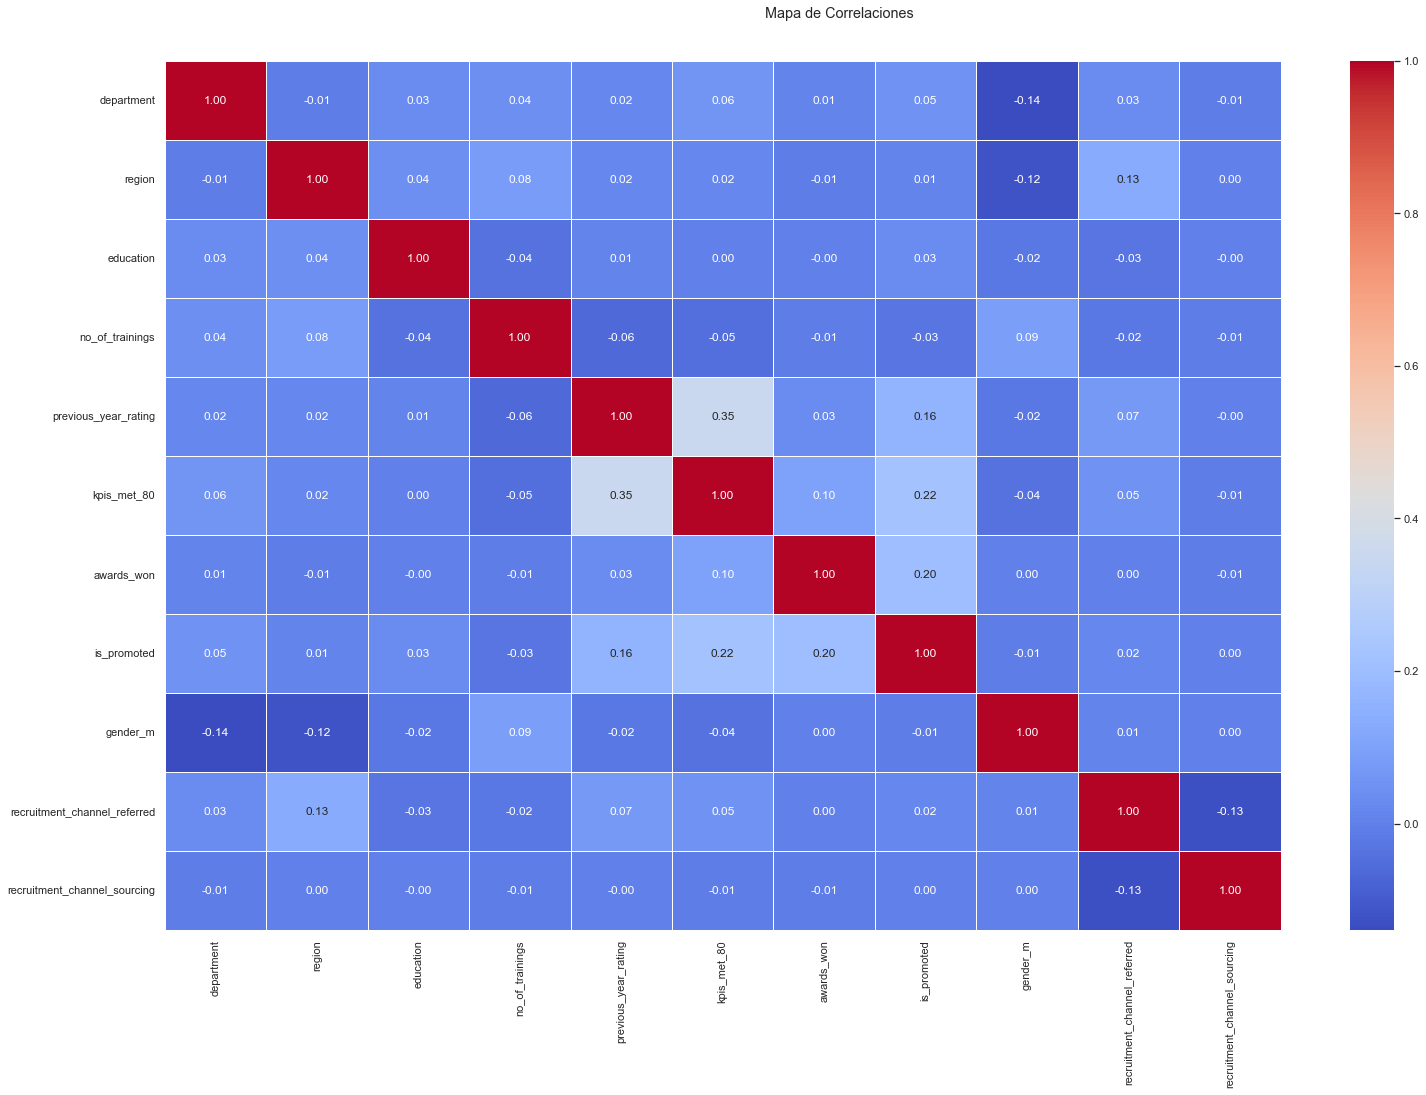

In [64]:
sns.set()

fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(round(dummies_corr, 2), annot=True, ax=ax, cmap='coolwarm',
            fmt='.2f', linewidths=0.5)
fig.subplots_adjust(top=0.93)
fig.suptitle('Mapa de Correlaciones');


In [65]:
X = promotion_cleaned_dummies.drop(['is_promoted','region'], axis=1)
y = promotion_cleaned_dummies[['is_promoted']]

print(y.value_counts())

is_promoted
0              44428
1               4232
dtype: int64


In [66]:
# Standardization of data #


# PredictorScaler=StandardScaler()
PredictorScaler=MinMaxScaler()

PredictorScalerFit = PredictorScaler.fit(X)

X =  PredictorScalerFit.transform(X)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# sm_smote = SMOTE()
sm_under = RandomUnderSampler()

# X_train, y_train = sm_smote.fit_resample(X_train, y_train)
X_train, y_train = sm_under.fit_resample(X_train, y_train)


# X_test, y_test = sm_smote.fit_resample(X_test, y_test)
X_test, y_test = sm_under.fit_resample(X_test, y_test)


(unique, counts)= np.unique(y_train, return_counts=True)
print((unique, counts))

counts[1]/counts[0]

(array([0, 1]), array([3365, 3365]))


1.0

In [68]:
len(y_train[y_train==0]), len(y_train[y_train==1])

(3399, 3399)

In [69]:
# Logistic Regression

lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)


print(classification_report(y_train, lr_clf.predict(X_train)))
print(confusion_matrix(y_train, lr_clf.predict(X_train)))

print()
print('------'* 10)
print()

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.69      0.70      3399
           1       0.70      0.73      0.72      3399

    accuracy                           0.71      6798
   macro avg       0.71      0.71      0.71      6798
weighted avg       0.71      0.71      0.71      6798

[[2350 1049]
 [ 923 2476]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       833
           1       0.70      0.72      0.71       833

    accuracy                           0.71      1666
   macro avg       0.71      0.71      0.71      1666
weighted avg       0.71      0.71      0.71      1666

[[578 255]
 [231 602]]


In [70]:
#Decision Trees

dtree_clf = DecisionTreeClassifier(max_depth=8)
dtree_fit = dtree_clf.fit(X_train,y_train)

y_pred2 = dtree_fit.predict(X_test) 


print(classification_report(y_train, dtree_fit.predict(X_train)))
print(confusion_matrix(y_train, dtree_fit.predict(X_train)))
print()
print('------'* 10)
print()

print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

print(dtree_fit.score(X_test, y_test))


              precision    recall  f1-score   support

           0       0.90      0.71      0.79      3399
           1       0.76      0.92      0.83      3399

    accuracy                           0.82      6798
   macro avg       0.83      0.82      0.81      6798
weighted avg       0.83      0.82      0.81      6798

[[2409  990]
 [ 263 3136]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.86      0.66      0.75       833
           1       0.73      0.89      0.80       833

    accuracy                           0.78      1666
   macro avg       0.79      0.78      0.77      1666
weighted avg       0.79      0.78      0.77      1666

[[553 280]
 [ 90 743]]
0.7779111644657863


In [71]:
#Random Forest
forest = RandomForestClassifier(max_depth=4, n_jobs=-1) # n_estimators = # de árboles
forest_fit = forest.fit(X_train, y_train) 
forest_fit

RandomForestClassifier(max_depth=4, n_jobs=-1)

In [72]:
y_pred3 = forest_fit.predict(X_test)

In [73]:
print(classification_report(y_train, forest_fit.predict(X_train)))
print(confusion_matrix(y_train, forest_fit.predict(X_train)))
print()
print('------'* 10)
print()

print(classification_report(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))

print(dtree_fit.score(X_test, y_test))

print(precision_score(y_test,y_pred3 ))
print(recall_score(y_test,y_pred3 ))

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      3399
           1       0.71      0.88      0.79      3399

    accuracy                           0.76      6798
   macro avg       0.78      0.76      0.76      6798
weighted avg       0.78      0.76      0.76      6798

[[2197 1202]
 [ 409 2990]]

------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.84      0.62      0.71       833
           1       0.70      0.88      0.78       833

    accuracy                           0.75      1666
   macro avg       0.77      0.75      0.75      1666
weighted avg       0.77      0.75      0.75      1666

[[518 315]
 [102 731]]
0.7779111644657863
0.6988527724665392
0.8775510204081632


In [74]:
model_params = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy'],
            'min_samples_split': [1, 2, 3],
            'min_samples_leaf' : [1, 2, 3]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [i for i in range(100,800,200)],
            'criterion' : ['gini', 'entropy'],
            'max_depth': [50,60,70],
            'min_samples_split': [1, 2, 3],
            'min_samples_leaf' : [1, 2, 3],
            'n_jobs' : [-1]
        }
    },
    'logistic_reggresion' : {
        'model': LogisticRegression(),
        'params': {
            'solver': ['lbfgs', 'saga', 'liblinear'],
            'max_iter': [200],
            'penalty': ['l1', 'l2']
        }
    }
}

In [75]:
cv = RepeatedKFold(n_splits=5, n_repeats=10)

In [76]:
scores = []
start = datetime.now()
for model_name, model_attributes in model_params.items():
    grid_clf =  GridSearchCV(model_attributes['model'], model_attributes['params'], cv=cv, return_train_score=False, n_jobs=-1, verbose=1, scoring='roc_auc')
    grid_clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': grid_clf.best_score_,
        'best_params': grid_clf.best_params_
    })
end = datetime.now()
print(end-start)
results = pd.DataFrame(scores,columns=['model','best_score','best_params'])
results




Fitting 50 folds for each of 18 candidates, totalling 900 fits
Fitting 50 folds for each of 216 candidates, totalling 10800 fits
Fitting 50 folds for each of 6 candidates, totalling 300 fits
0:30:31.757939


,model,best_score,best_params
0,DecisionTree,0.823288,"{'criterion': 'gini', 'min_samples_leaf': 3, '..."
1,random_forest,0.884594,"{'criterion': 'entropy', 'max_depth': 50, 'min..."
2,logistic_reggresion,0.803640,"{'max_iter': 200, 'penalty': 'l1', 'solver': '..."


In [77]:
hyper_random_forest = results.loc[1,]['best_params']
hyper_random_forest

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 700,
 'n_jobs': -1}

In [93]:
random_forest2 = RandomForestClassifier(**hyper_random_forest)

In [94]:
forest_fit2 = random_forest2.fit(X_train, y_train) 
forest_fit2

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=2,
                       n_estimators=700, n_jobs=-1)

In [98]:
y_pred4 = forest_fit2.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred4))
print(confusion_matrix(y_test, y_pred4))
print(dtree_fit.score(X_test, y_test))
print(precision_score(y_test,y_pred4 ))
print(recall_score(y_test,y_pred4 ))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       867
           1       0.80      0.96      0.87       867

    accuracy                           0.86      1734
   macro avg       0.88      0.86      0.86      1734
weighted avg       0.88      0.86      0.86      1734

[[657 210]
 [ 31 836]]
0.8160322952710496
0.7992351816443595
0.9642445213379469
